To do a quick recap of previous steps, we first provide a brief description of each of the variables we build before. 


## Variables Dictionary 

Some of the variables that we have added in the feature engineer step are: 

* `offer completed`. Number of completed offers 
* `offer viewed`. Number of viewed offers 
* `offer recieved`. Number of offers received.
* `CR`. Offer's completition rate. 
* `AR`. Offer's attractiveness rate: 
* `DFR`. Difficulty rate. 
* `DDR`. Duration rate. 
* `RR`. Reward rate. 
* `avg_time_to_view_offer`. Average time in hours to view the offer. 
* `avg_time_to_complete_offer`. Average time in hours to complete the offer. 
* `avg_time_complete_to_view_offer`. Average time in hours to complete from viewing the offer. 
* `OC_H`. Frequency of High Income customers who completed the offer. 
* `OR_H`. Frequency of High Income customers who received the offer.	
* `OV_H`. Frequency of High Income customers who viewed the offer.
* `OC_S`. Frequency of Standard Income customers who completed the offer. 
* `OR_S`. Frequency of Standard Income customers who received the offer. 	
* `OV_S`. Frequency of Standard Income customers who viewed the offer.	
* `OC_T`. Frequency of Top Income customers who completed the offer.	
* `OR_T`. Frequency of Top Income customers who received the offer.	
* `OV_T`. Frequency of Top Income customers who viewed the offer.
* `OC_days_antiquity_mean`. Average antiquity in days of customer who completed the offer. 
* `OR_days_antiquity_mean`. Average antiquity in days of customer who received the offer.
* `OV_days_antiquity_mean`. Average antiquity in days of customer who viewed the offer.
* `OC_months_antiquity_mean`. Average antiquity in months of customer who completed the offer.
* `OR_months_antiquity_mean`. Average antiquity in months of customer who received the offer.
* `OV_months_antiquity_mean`. Average antiquity in months of customer who viewed the offer.

In [1]:
import pandas as pd 
import numpy as np 

# Set output preferences 
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Load data 
df_for_model = pd.read_csv('data/df_for_model.csv')

# Verify 
assert df_for_model.shape[0] > 0, "Data is null"

# Quick view 
df_for_model.head(3)

,reward,channels,difficulty,duration,offer_type,id,offer completed,offer received,offer viewed,CR,AR,DFR,DDR,RR,avg_time_to_view_offer,avg_time_to_complete_offer,avg_time_complete_to_view_offer,OC_H,OR_H,OV_H,OC_S,OR_S,OV_S,OC_T,OR_T,OV_T,OC_days_antiquity_mean,OR_days_antiquity_mean,OV_days_antiquity_mean,OC_months_antiquity_mean,OR_months_antiquity_mean,OV_months_antiquity_mean
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0,0.48,0.88,0.70,2.65,1.0,22.86,65.01,42.14,59.41,49.42,47.64,30.32,43.19,46.05,10.26,7.40,6.31,576.28,531.77,529.36,19.22,17.73,17.65
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0,0.44,0.96,0.70,2.24,1.0,17.97,50.57,32.60,58.73,48.88,49.09,29.76,43.43,43.33,11.50,7.68,7.58,586.30,530.80,529.60,19.53,17.69,17.64
2,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0,0.57,0.54,0.62,2.65,1.0,27.83,72.90,45.07,53.51,48.47,56.56,37.55,44.03,37.60,8.93,7.50,5.83,591.64,534.68,555.77,19.71,17.82,18.52


## Objective 

Despite only having 8 observations of offers, we choose to tackle a regression problem (particularly a linear model) with the variable `CR` and `AR` as objective variables. For example, if we decide to predict the completition rate (CR), we would consider variables like `avg_time_to_complete_offer`, `OC_H`, etc. In mathematical formulation, we have a linear model 

$$ CR = \alpha + \beta_{1}\text{avg_time_to_complete_offer} + \beta_{2}\text{OC_H} + \beta_{3}\text{OC_S} + ...,  $$

plus other variables to consider, where $\alpha$ is the slope and we could take a bayesian or frequentist approach to estimate the set of coefficients $\beta_{1}, \beta_{2}, ...,$. To do that, we first need to handle the remaining categorical variables `offer_type`.

## Handling Categorical Variables

To distinguish betwen a `bogo` or `discount` offer, we're going to binary encode the values. 

* `bogo` ---> 1 
* `discount` ---> 0

In [2]:
type_dict = {
    'bogo': 1, 
    'discount': 0
}

df_for_model.offer_type = df_for_model.offer_type.map(type_dict)

## Why a Bayesian Regression Model?

There are some assumptions that should be satisfied for a Linear Regression model, like the variables should be normally distributed or the variance is homokedastic. However, as we only have 8 observations, this is difficult to achieve. In that  case, we could go for a bayesian approach, basically it works by updating the final knowledge (the posterior)  with the distribution of the new data that is coming (the likelihood) multplied by the initial belief (the prior). Scikit learn provides a Bayesian Linear Regression model assuming that the covariates are distributed normally, for more see [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py).

As we don't have enough sample, we're going to boostrap `n` time the data, that is, if we have $k$ observation we're going to sample with replacemente $k-m$ samples with $m \geq 1$, then split the data in train-test and fit the model. Finally, our metric will be the Mean Absolute Percentage Error 

$$ MAPE = \dfrac{1}{n}\sum_{n}\dfrac{y_{n}-\hat{y_{n}}}{y_{n}}, $$

where $y_{n}$ is the real value and $\hat{y_{n}}$ is the predicted value. 

For the `Bayesian Ridge` estimator notice that we set `compute_score=True` because we want to calculate log marginal likelihood at every iteration, in other words, how good is our model doing. Additionally, `normalize=True` is set to have the covariates on the same scale. 

## Boostraping the data? 

As we only have eight samples, we can perform boostrap to estimate the error. Given a sample of size $n$, boostrap works by generating $m$ samples of size $n$ with replacement. For a theoretical description, check out this [article](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60), the image below is taken from that article.

![bootstrap.png](figs/bootstrap.png)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

# Define MAPE 
def mape(y_true, y_pred):  
    return np.sum(np.abs((y_true - y_pred)/y_true)*(1/len(y_true)))*100

# Define Bayesian Regression with Boostrap samples 
def reg_bootstrap(X,Y,n,size): 
    '''
       Perform Bayesian regression with n boostrap samples
       defined by size
    '''
    mape_scores = []
    pred_std = []
    params = []
    
    for _ in range(n): 
        # Bootstrap data 
        X_sampled = X.sample(n=size, replace=True)
        Y_sampled = Y[X_sampled.index]

        # Split in train-test 
        X_train, X_test, y_train, y_test = train_test_split(X_sampled, Y_sampled, test_size=0.5)

        # Initialize Bayesian Model
        clf = BayesianRidge(compute_score=True, normalize=True)
        
        # Fit model
        clf.fit(X_train, y_train)
        
        # Predictions
        y_pred, y_std = clf.predict(X_test, return_std=True)
        
        # Store score 
        mape_scores.append(mape(y_pred, y_test))
        pred_std.append(np.mean(y_std))
        
    return mape_scores, pred_std

In [5]:
%%time
# Set covariates, target variable
covariates = [
              'offer_type',
              'DFR',
              'DDR', 
              'RR', 
              'avg_time_to_complete_offer',
              'avg_time_complete_to_view_offer', 
              'OC_H', 
              'OC_S', 
              'OC_T',  
              'OC_months_antiquity_mean'
             ]
target_variable = 'CR'

# Filter by target, covariates 
X, Y = df_for_model[covariates], df_for_model[target_variable]

mape_scores, pred_std = reg_bootstrap(X, Y, n=50, size=8)

CPU times: user 837 ms, sys: 12 ms, total: 849 ms
Wall time: 849 ms


We see that most of the time the MAPE score is between 5 and 20%, with an average of 12%. However, there are some particular cases that this value can go above 50, that is an accuracy below 50%, but most of the time we're confident that this accuracy could go between 80% and 95%. 

Average MAPE Score: 12.065674959237056


Text(0.5, 1.0, 'Mape Score by iteration')

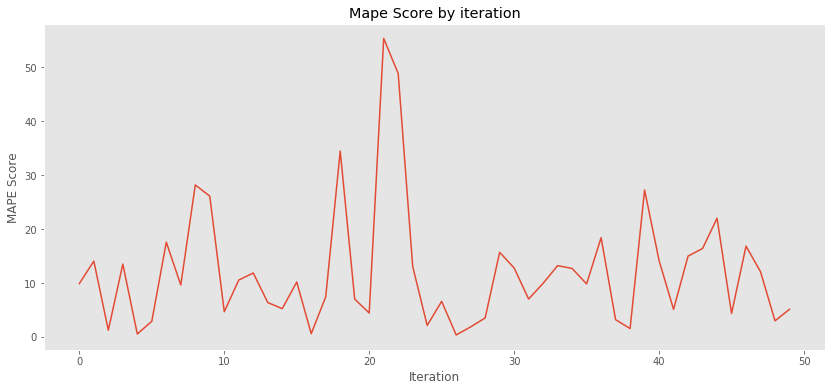

In [119]:
print(f'Average MAPE Score: {np.mean(mape_scores)}')
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
plt.plot(mape_scores)
plt.xlabel('Iteration')
plt.ylabel('MAPE Score')
plt.grid(False)
plt.title('Mape Score by iteration')

Equally likely, most of the time the model was confident about its predictions, with an average standard deviation prediction of 0.03 units away from the predicted value. 

Average Standard Deviaton of Prediction: 0.03970706186609471


Text(0.5, 1.0, 'Prediction Standard Deviation by iteration')

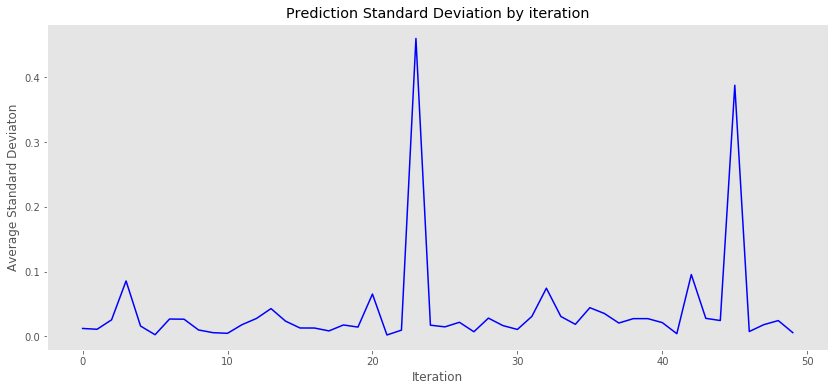

In [131]:
print(f'Average Standard Deviaton of Prediction: {np.mean(pred_std)}')
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
plt.plot(pred_std, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Average Standard Deviaton')
plt.grid(False)
plt.title('Prediction Standard Deviation by iteration')

## Upload data to S3 

Finally, before deploying the model, we upload the files to an S3 bucket.

In [17]:
from helpers import make_csv
import sagemaker

# Make csv file 
make_csv(X, Y, filename='train.csv', data_dir='data')

# Define session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# set prefix, a descriptive name for a directory  
prefix = 'capstone_project'

# upload all data to S3
sagemaker_session.upload_data(bucket=bucket, path='data', key_prefix=prefix)

Path created: data/train.csv


's3://sagemaker-us-west-2-216538981855/capstone_project'

## Recap 

We decided to build a Bayesian Linear Regression model to predict the completition rate of each offer. Basically, we choose a bayesian approach because we have very few observations (only eight), to mitigate this issue we choose to generate $n$ samples through bootstraping of the same size as the origina sample. On average, the $MAPE$ is around 12% and the prediction confidence or standard deviations is on average .03. A good model given the limitations of the data. 

In the following notebook `Model_Deployment` we're going to be using the SageMaker's SKlearn estimator to deploy the Bayesian Linear Regression Model.